# Project 1 on Machine learning - Notebook

This notebook contains all the code developed to solve the tasks of Project 1. Note that this is meant to serves as additional material corresponding to the Project Report delivered in PDF format.

## Exercise 1

In [1]:
from decimal import Decimal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
import numpy as np
from random import random, seed
from sklearn.model_selection import  train_test_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from scipy import linalg
from imageio import imread
from sklearn.pipeline import make_pipeline

#### Generate data for Franke Function f(x, y) with $x, y \in [0,1] $
Data both with and without stochastic noise is created.

In [165]:
#Function to generate data
def generateFrankeData(N,sigma): 
    np.random.seed(2022)
    x = np.sort(np.random.uniform(0, 1, N)).reshape(-1, 1)
    y = np.sort(np.random.uniform(0, 1, N)).reshape(-1, 1)
    x, y = np.meshgrid(x,y)
    
    #Calculate z from frankefunciton
    z = FrankeFunction(x,y)
    
    #Noise is generated according to a normal distribution
    noise = np.random.normal(0, sigma, z.shape)
    z += noise   #adding noise 
        
    return np.ravel(x), np.ravel(y), np.ravel(z)
#Function to generate data
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    z = term1 + term2 + term3 + term4          
    return z

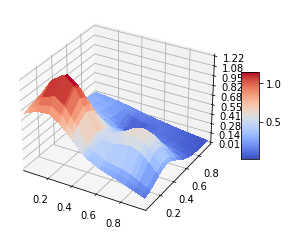

In [3]:
def plot_surface(x,y,z,N,filename=None):
    #reshape in case array is raveled
    if(len(x.shape)<2):
        x = x.reshape(N,N)
    if(len(y.shape)<2):
        y = y.reshape(N,N)       
    if(len(z.shape)<2):
        z = z.reshape(N,N)  
        
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    #ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    
    ax.set_xlim3d(np.min(x), np.max(x))
    ax.set_ylim3d(np.min(y), np.max(y))
    ax.set_zlim3d(np.min(z), np.max(z))
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.4, aspect=5)
    if (filename):
        plt.savefig(filename)
        
    plt.show()
    
N = 30
sigma = 0
x,y,z = generateFrankeData(N,sigma)

plot_surface(x,y,z,N,"franke_0")


#### Create design matrix using polynomials in x and y up to fifth order

In [4]:
def create_X(x, y, degree):
    #In case x and y are matrices, ravel them
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
        
    N = len(x)
    l = int((degree+1)*(degree+2)/2)   # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,degree+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X

#### Split the data using scikit train_test_split. Then scale the data by subtracting the mean and diving by standard deviation

In [5]:
#Manually scale data with X_train mean
def scale_data(trf_data, mean, std=1):
    return np.divide(trf_data - mean, std, where=std!=0, out = np.zeros_like(trf_data))

def unscale_data(trf_data, mean, std=1):    
    return trf_data*std + mean

#### Least square regression manually implemented
Regression is implemented by 'manual' inversion of matrices. Calculation of confidence interval implemented

In [6]:
def SVD(A):
    ''' Takes as input a numpy matrix A and returns inv(A) based on singular value decomposition (SVD).
    SVD is numerically more stable than the inversion algorithms provided by
    numpy and scipy.linalg at the cost of being slower.
    '''
    U, S, VT = np.linalg.svd(A,full_matrices=True)
    D = np.zeros((len(U),len(VT)))
    
    # D is the sudo inverse of sigma
    for i in range(0,len(VT)):
        if (S[i] == 0):
            D[i,i] = 0
        else:
            D[i,i]=1/S[i]
    
    return VT.T @ D @ U.T

def fit_beta(X_train, z_train):
    '''
    Calculates optimal beta from training data.
    Inputs
    X_train: Training design matrix
    z_train: Training target data
    
    Returns
    beta: Optimal parameters
    XTX_inv: Inverse of XTX(used for confidence intervals)
    '''
    XTX_inv = np.linalg.pinv(X_train.T @ X_train) #inverse
    beta = XTX_inv @ X_train.T @ z_train          #optimal parameters
    return beta, XTX_inv


def fit_beta2(X_train, z_train):
    '''
    Calculates optimal beta from training data.
    Inputs
    X_train: Training design matrix
    z_train: Training target data
    
    Returns
    beta: Optimal parameters
    XTX_inv: Inverse of XTX(used for confidence intervals)
    '''
    
    XTX_inv = SVD(X_train.T @ X_train) #inverse
    beta = XTX_inv @ X_train.T @ z_train          #optimal parameters
    return beta, XTX_inv

def calc_ci(beta, XTX_inv, sigma):
    '''
    Calculates 95% confidence interval of beta
    Inputs
    beta: optimal parameters
    XTX_inv: inverse of XTX matrix
    sigma: standard deviation of noise term
    '''
    
    VarBeta = sigma**2 * np.diag(XTX_inv)          #calculate variance of beta
    conf_intervals = np.column_stack((beta - 1.96*(VarBeta**0.5), 
                                  beta + 1.96*(VarBeta**0.5))) #construct ci

    return conf_intervals

#### Studying the effect of noise term on beta
A polynomial degree of 3 is used with varying sigma to study the effect the noise term has on the optimal parameters.
A for loop is first employed to generate data, calculate beta, confidence intervals and variances for each of the sigma values.
After which a double for loop is used to produce Latex table friendly text. Lastly, the variances for the different betas are plotted.

In [ ]:
#An arbitrary random seed is set to make reproducible results
np.random.seed(2022)

#100 data points is used
N = 100

#Studying three different sigmas
sigmas = [0, 0.3, 1]
split = 0.2
degree = 5
#Creating arrays to store results in loop
n_features = int((degree+1)*(degree+2)/2)
beta_sigmas = np.zeros(shape=(n_features,len(sigmas)))
ci_sigmas = np.zeros(shape=(len(sigmas),n_features, 2))
varBetas = np.zeros(shape=(n_features,len(sigmas)))

#Generate data and calculate beta, var and ci for each sigma value
for i in range(len(sigmas)):
    x,y,z = generateFrankeData(N,sigmas[i])
    X = create_X(x,y,degree)
    X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=split,random_state = 42)
    
    beta, XTX_inv = fit_beta(X_train,z_train)

    beta_sigmas[:,i] = beta
    ci_sigmas[i,:,:] = calc_ci(beta,XTX_inv,sigmas[i])
    varBetas[:,i] = sigmas[i]**2 * np.diag(XTX_inv)

#Printing the reults in Latex Table format
for i in range(n_features): 
    i_str = str(i)
    a = "\\"
    b_string = ""
    for j in range (len(sigmas)):
        b_string += "& {:.1f} [{:.1f} {:.1f}]".format(beta_sigmas[i][j],ci_sigmas[j,i,0],ci_sigmas[j,i,1])

    #conf = str(conf_intervals[i])
    print(a+"("+a+"beta_{"+i_str+"}\) "+b_string+a+a)

print([i for i in range(10)])
#Plotting variances sigma=1
plt.bar([i for i in range(n_features)],varBetas[:,2], label= "Sigma = 1")
plt.bar([i for i in range(n_features)],varBetas[:,1],label = "Sigma = 0.3")
plt.bar([i for i in range(n_features)],varBetas[:,0],label = "Sigma = 0")
plt.xlabel('Feature #')
plt.ylabel('Variance')
plt.legend()
#plt.savefig("Varbeta_impact.png")

#### Demonstrating equal parameters(except intercept) when centering the data

In [ ]:
N = 1000
degree = 3
sigma = 0.3
np.random.seed(2022)
x,y,z = generateFrankeData(N,sigma)
X = create_X(x,y,degree)
#Split data
X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2, random_state = 42)

#Calc mean
mean_X_train = np.mean(X_train,axis=0)
mean_z_train = np.mean(z_train,axis = 0)

#Center the data
X_train_centered =scale_data(X_train, mean_X_train, 1)
X_test_centered = scale_data(X_test, mean_X_train, 1)
z_train_centered = scale_data(z_train, mean_z_train, 1)

beta_1,_ = fit_beta(X_train,z_train)
beta_2,_ =fit_beta(X_train_centered,z_train)
beta_3,_ = fit_beta(X_train_centered,z_train_centered)

#Dataframe for readability
beta_df = pd.DataFrame(np.column_stack((beta_1,beta_2,beta_3)), columns = ['Original', 'Centered X', 'Centered X and z'])
beta_df.index.name = "beta"

print(beta_df)

#### Demonstrating the change in beta when standardizing
It can be observed from the result of running the code below that fitting beta to standardized data, is equal to scaling each of the parameters by the standard deviation of the column.
$$
\beta_jS_j = \beta^{standardized}_j 
$$

In [ ]:
#Split data
X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2, random_state = 42)

#Calc mean
mean_X_train = np.mean(X_train,axis=0)
mean_z_train = np.mean(z_train,axis = 0)
std_X_train = np.std(X_train,axis=0)
std_z_train = np.std(z_train,axis=0)

#Center the data
X_train_standardized =scale_data(X_train, mean_X_train, std_X_train)
X_test_standardized = scale_data(X_test, mean_X_train, std_X_train)
z_train_standardized = scale_data(z_train, mean_z_train, std_z_train)

#Beta is fitted with different data to explore the differences
beta_1,_ = fit_beta(X_train,z_train)
beta_2,_ =fit_beta(X_train_standardized,z_train)
beta_3,_ = fit_beta(X_train_standardized,z_train_standardized)

#Dataframe for readability
beta_df = pd.DataFrame(np.column_stack((beta_1,beta_2,beta_3,
                                        np.divide(beta_2,beta_1, 
                                                  where=beta_1!=0,
                                                  out=np.zeros_like(beta_2)),
                                        std_X_train)), 
                       columns = ['beta_1', 'beta_2', 
                                  'beta_3', 'beta_2/beta_1', 
                                  'std_X_train'])
beta_df.index.name = "beta"

print(beta_df)

#### Calculate $MSE$ and $R^{2}$

In [7]:
def R2(z_data, z_model):
    '''
    Returns the R2 score for z_data and z_model
    '''
    return 1 - np.sum((z_data - z_model) ** 2) / np.sum((z_data - np.mean(z_data)) ** 2)

def MSE(z_data,z_model):
    '''
    Returns the MSE for z_data and z_model
    '''
    n = np.size(z_model)
    return np.sum((z_data-z_model)**2)/n


def model_predict(X_data, beta):
    '''
    Predicts the output data of X_data using beta
    '''
    return X_data @ beta

In [ ]:
#An arbitrary random seed is set to make reproducible results
np.random.seed(2022)

sigma = 0.3
N = 30
max_degree = 5
n_features = int((max_degree+1)*(max_degree+2)/2)
x,y,z = generateFrankeData(N,sigma)

#arrays to capture MSE and R2
MSE_train = np.zeros(max_degree+1)
MSE_test = np.zeros(max_degree+1)
R2_train = np.zeros(max_degree+1)
R2_test = np.zeros(max_degree+1)


beta_degrees = pd.DataFrame()
variances = pd.DataFrame()
for degree in range(max_degree+1):
    X = create_X(x,y,degree)
    X_train, X_test, z_train, z_test = train_test_split(X, z,test_size=0.2 , random_state = 42)
    beta, XTX_inv = fit_beta(X_train, z_train)
    var = sigma**2 * np.diag(XTX_inv)
    z_tilde = model_predict(X_train,beta)
    z_pred = model_predict(X_test,beta)
    
    MSE_train[degree] = MSE(z_train,z_tilde)
    MSE_test[degree] = MSE(z_test,z_pred)
    R2_train[degree] = R2(z_train,z_tilde)
    R2_test[degree] = R2(z_test,z_pred)
    
    z_checking,_ = fit_beta(np.eye(X_test.shape[0]),z_test)

    df_v = pd.DataFrame(data = var,index=range(beta.shape[0]),columns=['Degree '+str(degree)])
    df_b = pd.DataFrame(data = beta,index=range(beta.shape[0]),columns=['Degree '+str(degree)])
    variances = pd.concat([variances,df_v],axis=1)
    beta_degrees = pd.concat([beta_degrees,df_b],axis=1)

scores_df = pd.DataFrame()
scores_df['Train MSE'] = MSE_train.tolist()
scores_df['Test MSE'] = MSE_test.tolist()
scores_df['Train R2'] = R2_train.tolist()
scores_df['Test R2'] = R2_test.tolist()
print(scores_df)
#beta_degrees.index.name = "beta"
#print(variances)
print(beta_degrees)

plt.plot(MSE_train,label="MSE train")
#plt.plot(MSE_test2,label="MSE test2")
plt.plot(MSE_test,label="MSE test")
plt.xlabel('Polynomial degree')
plt.ylabel('Error')
plt.legend()
#plt.savefig("trainTest_MSE_30_ran2.png")

In [ ]:
plt.plot(R2_train,label="R2 train")
plt.plot(R2_test,label="R2 test")
plt.xlabel('Polynomial degree')
plt.ylabel('R2 score')
plt.legend()
#plt.savefig("trainTest_R2_100_1.png")

In [ ]:
plt.xlabel('Polynomial degree')
plt.ylabel('Variance')
plt.plot(variances.loc[1],label='beta1')
plt.plot(variances.loc[2],label='beta2')
plt.legend()
#plt.savefig("Varbeta_degree_impact.png")

#### Plotting MSE vs std of noise term

In [ ]:
N = 30
degree = 7
nsigma = 100
maxsigma = 10
sigmas = np.arange(0,maxsigma,maxsigma/nsigma)

MSE_train = np.zeros(nsigma)
MSE_test = np.zeros(nsigma)


for i in range(nsigma):
    x, y, z = generateFrankeData(N, sigmas[i])   
    X = create_X(x, y, degree)
    
    #Split data
    X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2, random_state = 42)
    beta, _ = fit_beta(X_train, z_train)
    
    #Predict train data and calculate MSE and R2
    z_tilde = model_predict(X_train, beta)
    MSE_train[i] = MSE(z_train,z_tilde)

    #Predict test data and calculate MSE and R2
    z_pred = model_predict(X_test, beta)
    MSE_test[i] = MSE(z_test,z_pred)   
    
plt.figure()
plt.plot(sigmas, MSE_train, 'b', label = 'MSE_train')
plt.plot(sigmas, MSE_test, 'y', label = 'MSE_test')

plt.xlabel('sigma')
plt.ylabel('MSE')
plt.savefig("MSE_vs_noise_7.png")
plt.legend()
plt.show()

## Exercise 2

### Bootstrap
Functions defined for bootstrap. Note that both train and test predictions must be done inside the loop directly after resampling to ensure the train and test error is based on the same resample. The train MSE can be calculated directly and returned, however, the test predictions are returned directly to allow further calculations(bias and variance).

In [8]:
def bootstrap(X_train, z_train, X_test, n_bootstraps):
    z_pred = np.empty((X_test.shape[0], n_bootstraps))
    z_tilde = np.empty((X_train.shape[0], n_bootstraps))   
    MSE_train_acc = 0 #MSE accumulator
    
    for i in range(n_bootstraps):
        X_,z_ = resample(X_train, z_train)         #random resampling 
        beta_, _ = fit_beta(X_,z_)                 #fit beta to new resampled data
        z_pred[:,i] = model_predict(X_test, beta_) #predict test data
        z_tilde = model_predict(X_, beta_)         #predict train data
        MSE_train_acc += MSE(z_,z_tilde)           #accumulate train MSE
    return z_pred, MSE_train_acc/n_bootstraps

### OLS Train and test error
Bootstrap is used to calculate MSE

#### MSE is calculated as a function of polynomial degree(complexity)
The mean squared error on the test data initially decreases increased complexity. However, after degree 6 it increaes due to overfitting.

In [ ]:
sigma = 0.3
N = 30
x, y, z = generateFrankeData(N, sigma)
max_degree = 15
MSE_train = np.zeros(max_degree+1)
MSE_test = np.zeros(max_degree+1)
n_bootstraps = 50
xy_train, xy_test, z_train, z_test = train_test_split(np.column_stack((x,y)),z,test_size=0.2, random_state = 42)
for i in range(max_degree+1):
    X_train = create_X(xy_train[:,0], xy_train[:,1], i)
    X_test = create_X(xy_test[:,0], xy_test[:,1], i)
    
    #Predict train data and calculate MSE and R2
    #MSE_train[i] = bootstrap_train(X_train,z_train, n_bootstraps)   

    #Predict test data and calculate MSE and R2
    z_pred, MSE_train[i] = bootstrap(X_train,z_train, X_test, n_bootstraps)
    
    MSE_test[i] = np.mean( np.mean((z_test.reshape(-1,1) - z_pred)**2, axis=1, keepdims=True) )
    
plt.figure()
plt.plot(MSE_train, label = 'MSE_train')
plt.plot(MSE_test, label = 'MSE_test')


plt.xlabel('degree')
plt.ylabel('MSE')
plt.legend()
#plt.savefig("trainTest_MSE_30_bootstrap.png")
plt.show()
print(np.min(MSE_test))

In [9]:
def bootstrap_sk(X_train, z_train, X_test, n_bootstraps,reg):
    z_pred = np.empty((X_test.shape[0], n_bootstraps))
    for i in range(n_bootstraps):
        X_,z_ = resample(X_train, z_train)
        reg = reg.fit(X_,z_)
        z_pred[:,i] = reg.predict(X_test)[:,0]

    return z_pred

In [ ]:
n_bootstraps = 50
max_degree = 15
sigma = 0.3
N = 30
x, y, z = generateFrankeData(N, sigma)
error = np.zeros(max_degree+1)
#error2 = np.zeros(max_degree+1)
bias = np.zeros(max_degree+1)
variance = np.zeros(max_degree+1)
degrees_arr = np.arange(max_degree+1)

xy_train, xy_test, z_train, z_test = train_test_split(np.column_stack((x,y)),z,test_size=0.2, random_state = 42)
#mean_z_train = np.mean(z_train,axis = 0)
#std_z_train = np.std(z_train, axis = 0)

#z_train =  scale_data(z_train, mean_z_train, std_z_train)
#z_test =  scale_data(z_test, mean_z_train, std_z_train)

for degree in range(max_degree+1):
    X_train = create_X(xy_train[:,0], xy_train[:,1], degree)
    X_test = create_X(xy_test[:,0], xy_test[:,1], degree)
    
    #Bootstrapping
    z_pred, _ = bootstrap(X_train, z_train, X_test, n_bootstraps)
       
    z_test = z_test.reshape(-1,1)
    #Calculating MSE bias and variance
    error[degree] = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(z_pred, axis=1, keepdims=True) )

plt.figure()
plt.plot(degrees_arr,error, label='Error')
plt.plot(degrees_arr,bias, label='bias')
plt.plot(degrees_arr,variance, label='Variance')

plt.xlabel('degree')
#plt.ylabel('MSE')
plt.legend()
#plt.savefig("biasVariance_20_15.png")
plt.show()

In [ ]:
plt.figure()
plt.plot(degrees_arr,error, label='Error')
plt.plot(degrees_arr,bias, label='bias')
plt.plot(degrees_arr,variance, label='Variance')

plt.xlabel('degree')
#plt.ylabel('MSE')
plt.legend()
#plt.savefig("biasVariance_MSE_30.png")
plt.show()

## Exercise 3

### Cross-validation

In [10]:
def crossVal(kfold, X, z):
    j = 0
    scores_KFold_train = np.zeros((kfold.get_n_splits()))
    scores_KFold_test = np.zeros((kfold.get_n_splits()))
    for train_inds, test_inds in kfold.split(X):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]
        
        beta, _ = fit_beta(X_train, z_train)

        #Predict test data and calculate MSE
        z_tilde = model_predict(X_train, beta)
        z_pred = model_predict(X_test, beta)

        scores_KFold_train[j] = MSE(z_train, z_tilde)
        scores_KFold_test[j] = MSE(z_test, z_pred)
        j += 1 
    return scores_KFold_train, scores_KFold_test
def crossVal_sk(kfold, X, z):
    j = 0
    scores_KFold_train = np.zeros((kfold.get_n_splits()))
    scores_KFold_test = np.zeros((kfold.get_n_splits()))
    for train_inds, test_inds in kfold.split(X):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]
        beta, _ = fit_beta(X_train, z_train)
        
        lin = LinearRegression(fit_intercept=False)
        lin = lin.fit(X_train, z_train)
        lin.coef_ = beta.T
        #lin.intercept_ = 0
        z_tilde = lin.predict(X_train)
        z_pred = lin.predict(X_test)


        scores_KFold_train[j] = MSE(z_train, z_tilde)
        scores_KFold_test[j] = MSE(z_test, z_pred)
        j += 1 
    return scores_KFold_train, scores_KFold_test

In [ ]:
# Initialize a KFold instance
k = 5
max_degree = 15
sigma = 0.3
N = 30
x, y, z = generateFrankeData(N, sigma)
kfold = KFold(n_splits = k, shuffle=True, random_state = 5)
#degrees_arr = np.arange(0,max_degree+1)

# Perform the cross-validation to estimate MSE
scores_KFold_train = np.zeros((max_degree+1, k))
scores_KFold_test = np.zeros((max_degree+1, k))
sk_scores_KFold_train = np.zeros(max_degree+1)

for i in range(max_degree+1):
    X = create_X(x, y, i)
    #Calc mean and std
    scores_KFold_train[i,:], scores_KFold_test[i,:] = crossVal(kfold, X, z)
    scores_KFold_train[i,:], scores_KFold_test[i,:] = crossVal_sk(kfold, X, z)

    #sk_scores_KFold_train[i] = np.mean(cross_val_score(lin, X, z, scoring=make_scorer(mean_squared_error), cv=k))

mse_KFold_train = np.mean(scores_KFold_train, axis = 1)
mse_KFold_test = np.mean(scores_KFold_test, axis = 1)

plt.figure()
plt.plot(mse_KFold_train, label='Train error')
plt.plot(mse_KFold_test, label='Test error')


plt.xlabel('degree')
plt.ylabel('MSE')
plt.legend()
#plt.savefig("crossval_.png")
plt.show()
print(np.argmin(mse_KFold_test))
print(np.min(mse_KFold_test))

## Exercise 4
### Ridge regression
#### Running bootstrap analysis

In [78]:
def fit_beta_ridge(X_train, z_train, lmb):
    '''Fitting beta with ridge is similar to OLS. Small values according
    are added across the diagonal of the matrix to be inversed.
    This is also a way to ensure the matrix is not singular.'''
    I =  np.eye(X_train.shape[1],X_train.shape[1])
    XTX_inv = np.linalg.pinv(X_train.T @ X_train+ lmb*I)
    beta = XTX_inv @ X_train.T @ z_train
    return beta, XTX_inv


def bootstrap_ridge_sk(X_train, z_train, X_test, n_bootstraps, lmb):
    #Function for demonstration purposes
    z_pred = np.empty((X_test.shape[0], n_bootstraps))
    ridge = Ridge(alpha=lmb)
    for i in range(n_bootstraps):
        X_,z_ = resample(X_train, z_train)
        ridge = ridge.fit(X_,z_)
        z_pred[:,i] = ridge.predict(X_test)[:,0]
    return z_pred



def crossVal_ridge(kfold, X, z, lmb):
    '''
    For loop iterates through kfold.split(X) which is a tuple containing indices
    for test and train data.
    When indexing X and z with these, train and test data is extracted.
    '''
    j = 0
    #Array to capture scores
    scores_KFold = np.zeros((kfold.get_n_splits()))
    for train_inds, test_inds in kfold.split(X):
        
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]

        '''
        All data is scaled, both design matrix, train data and
        test data. As such, intercept does not have to be added at the end
        '''
        mean_X_train = np.mean(X_train,axis=0)
        std_X_train = np.std(X_train, axis = 0)
        mean_z_train = np.mean(z_train,axis = 0)
        std_z_train = np.std(z_train, axis = 0)
        
        #Scale data
        X_train = scale_data(X_train,mean_X_train,1)
        X_test = scale_data(X_test, mean_X_train,1)

        z_train =  scale_data(z_train, mean_z_train, 1)
        z_test =  scale_data(z_test, mean_z_train, 1)
       
        beta, _ = fit_beta_ridge(X_train, z_train, lmb)

        
        #Predict test data and calculate MSE
        z_pred = model_predict(X_test, beta) 
        scores_KFold[j] = MSE(z_test, z_pred)
        j += 1 
    return scores_KFold

def bootstrap_ridge(X_train, z_train, X_test, n_bootstraps,lmb):
    z_pred = np.empty((X_test.shape[0], n_bootstraps))
    for i in range(n_bootstraps):
        '''
        Note that data must be scaled after every resample
        '''
        X_,z_ = resample(X_train, z_train)
        mean_z =np.mean(z_train,axis = 0)
        mean_X =np.mean(X_train,axis=0)
        X_ = scale_data(X_,mean_X)
        z_ = scale_data(z_,mean_z)

        #Fitting beta to resampled data
        beta_, _ = fit_beta_ridge(X_,z_,lmb)

        
        #Calculating the intercept
        intercept_ = mean_z - mean_X@beta_
        '''
        In this case intercept is added'''
        z_pred[:,i] = model_predict(X_test, beta_) + intercept_
    return z_pred

def bootstrap_ridge_train(X_train, z_train, n_bootstraps,lmb):
    z_tilde = np.empty((X_train.shape[0], n_bootstraps))
    MSE_train_acc = 0
    for i in range(n_bootstraps):
        X_,z_ = resample(X_train, z_train)
        mean_z =np.mean(z_train,axis = 0)
        mean_X =np.mean(X_train,axis=0)
        X_ = scale_data(X_,mean_X)
        z_ = scale_data(z_,mean_z)        
        beta_, _ = fit_beta_ridge(X_,z_,lmb)
        z_tilde = model_predict(X_, beta_)
        MSE_train_acc += MSE(z_,z_tilde)
        
    return MSE_train_acc/n_bootstraps

### Ridge test
The written ridge code is tested by setting lambda = 0. Beta should then be exactly the same as OLS

In [ ]:
degree = 5
sigma = 0.3
N = 100
x,y,z = generateFrankeData(N,sigma)
X = create_X(x,y,degree)
X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2, random_state = 42)

#Calculating OLS parameters
beta_ols,XTX_inv = fit_beta(X_train,z_train)
varBeta= sigma**2 * np.diag(XTX_inv)


#Calculating Ridge parameters with lmb=0
lmb = 0
beta_ridge1,_ = fit_beta_ridge(X_train,z_train,lmb)

#Calculating Ridge parameters with lmb=0.1
lmb = 0.001
beta_ridge2,_ = fit_beta_ridge(X_train,z_train,lmb)

#Calc mean and std
mean_X_train = np.mean(X_train,axis=0)
std_X_train = np.std(X_train, axis = 0)
mean_z_train = np.mean(z_train,axis = 0)
std_z_train = np.std(z_train, axis = 0)

#Scale data
X_train = scale_data(X_train,mean_X_train)
X_test = scale_data(X_test, mean_X_train)
z_train =  scale_data(z_train, mean_z_train)


#Calculating Ridge parameters with lmb=0.1
lmb = 0.001
beta_ridge3,_ = fit_beta_ridge(X_train,z_train,lmb)

df = pd.DataFrame(np.column_stack((beta_ols,beta_ridge1,beta_ridge2,beta_ridge3)), columns = ['OLS', 'Ridge lmb= 0', 
                                                                                              'Ridge(lmb=0.001)', 
                                                                                              'Ridge centered(lmb=0.001)'])
df.index.name = "beta"
print(df)

As seen in the result, ridge dampens the fluctuations drastically.

#### Ridge train and test error

In [ ]:
sigma = 0.3
N = 30
max_degree = 15
x,y,z = generateFrankeData(N,sigma)
lmb = 0.001
n_bootstraps = 50
MSE_train = np.zeros(max_degree+1)
MSE_test = np.zeros(max_degree+1)

xy_train, xy_test, z_train, z_test = train_test_split(np.column_stack((x,y)),z,test_size=0.2, random_state = 42)

                     
for i in range(max_degree+1):
    X_train = create_X(xy_train[:,0], xy_train[:,1], i)
    X_test = create_X(xy_test[:,0], xy_test[:,1], i)
    
    MSE_train[i] = bootstrap_ridge_train(X_train,z_train, n_bootstraps,lmb)   

    #Predict test data and calculate MSE and R2
    z_pred = bootstrap_ridge(X_train,z_train, X_test, n_bootstraps,lmb)
    MSE_test[i] = np.mean( np.mean((z_test.reshape(-1,1) -z_pred)**2, axis=1, keepdims=True) )
 


plt.figure()
plt.plot(MSE_train, label = 'MSE_train')
plt.plot(MSE_test, label = 'MSE_test')


plt.xlabel('degree')
plt.ylabel('MSE')
plt.legend()
#plt.savefig("Ridge_trainTest_30.png")
plt.show()

It is clear that Ridge regression delays the increasing of test MSE as degree increases.

### Ridge bias-variance trade-off

In [ ]:
sigma = 0.3
N = 30
max_degree = 30
x,y,z = generateFrankeData(N,sigma)
lmb = 0.0002
n_bootstraps = 50

error = np.zeros(max_degree+1)
bias = np.zeros(max_degree+1)
variance = np.zeros(max_degree+1)

error2 = np.zeros(max_degree+1)
bias2 = np.zeros(max_degree+1)
variance2 = np.zeros(max_degree+1)

xy_train, xy_test, z_train, z_test = train_test_split(np.column_stack((x,y)),z,test_size=0.2, random_state = 42)
#z_test = z_test.reshape(-1,1)

for degree in range(max_degree+1): 
    #model = make_pipeline(PolynomialFeatures(degree=degree),Ridge(alpha=lmb))
    X_train = create_X(xy_train[:,0], xy_train[:,1], degree)
    X_test = create_X(xy_test[:,0], xy_test[:,1], degree)

    #Bootstrapping
    z_pred = bootstrap_ridge(X_train, z_train, X_test, n_bootstraps, lmb)
    
    #z_pred = np.empty((xy_test.shape[0], n_bootstraps))
    #for i in range(n_bootstraps):
        #xy_, z_ = resample(xy_train, z_train)
        #z_pred[:, i] = model.fit(xy_, z_).predict(xy_test).ravel()
        
    #print(z_pred.shape)
    z_test = z_test.reshape(-1,1)
    #Calculating MSE bias and variance
    error[degree] = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(z_pred, axis=1, keepdims=True) )
    
    #error2[degree] = np.mean( np.mean((z_test.reshape(-1,1) -z_pred2)**2, axis=1, keepdims=True) )
    #bias2[degree] = np.mean( (z_test - np.mean(z_pred2, axis=1))**2 )
    #variance2[degree] = np.mean(np.var(z_pred2,axis=1))


plt.figure()
plt.plot(error, label='Error')
plt.plot(bias, label='bias')
plt.plot(variance, label='Variance')

plt.xlabel('degree')
#plt.ylabel('MSE')
plt.legend()
#plt.savefig("Ridge_biasVariance_10.png")
plt.show()

Again, Ridge pushes the point where variance is more than bias towards higher degrees. If code above is runned with fewer data points, variance should exceed the bias earlier. Note that with fewer data points, fewer bootstraps are needed. A rule of thumb is that you don't need more bootstraps than number of data.

### Ridge lambda optimization with cross-validation
In this code, cross-validation is used to find the optimal lambda for a chosen degree. A loop iterates several lambdas we wish to test, inside the crossVal function is called on each iteration, which returns the cross validated score for current hyperparameters.

Minimum error:  0.09364655926149176
Lambda resulting in minimum error:  0.0002656087782946689


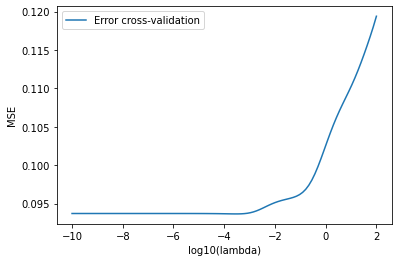

In [154]:
sigma = 0.3
N = 30
degree = 4
x,y,z = generateFrankeData(N,sigma)

nlambdas = 100
lambdas = np.logspace(-10, 2, nlambdas)
k = 5
kfold = KFold(n_splits = k,shuffle=True, random_state = 5)



# Perform the cross-validation to estimate MSE
scores_KFold = np.zeros((nlambdas, k))
scores = np.zeros((nlambdas, k))

for i in range(nlambdas):
    lmb = lambdas[i]
    X = create_X(x, y, degree)
    #Calc mean and std
    scores_KFold[i,:] = crossVal_ridge(kfold, X, z, lmb)
    
    clf = Ridge(alpha=lmb)
    scores[i,:] = cross_val_score(clf, X, z, cv=k, scoring='neg_mean_squared_error')


estimated_mse_KFold = np.mean(scores_KFold, axis = 1)
estimated_mse_KFold_sk = np.mean(-scores,axis=1)


plt.figure()
plt.plot(np.log10(lambdas), estimated_mse_KFold, label='Error cross-validation')
#plt.plot(np.log10(lambdas),estimated_mse_KFold_sk,"--", label='Error cross-validation sklearn')
print("Minimum error: ",np.min(estimated_mse_KFold))
print("Lambda resulting in minimum error: ",lambdas[np.argmin(estimated_mse_KFold)])
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.savefig("bestlamb_ridge.png")
plt.show()

There is a slight decrease in the beginning indicating that using Ridge(lambda>0) is at least apropriate. After a point lambda starts increasing which indicate there's an optimal value in terms of minimizing test error.

## Exercise 5
### Lasso regression

In [184]:
def bootstrap_lasso(X_train, z_train, X_test, n_bootstraps,lmb):
    lasso = Lasso(alpha = lmb,tol=0.1)
    z_pred = np.empty((X_test.shape[0], n_bootstraps))
    z_tilde = np.empty((z_train.shape[0]))
    MSE_train_acc = 0
    for i in range(n_bootstraps):
        X_,z_ = resample(X_train, z_train)
        lasso = lasso.fit(X_, z_)
        z_pred[:,i] = lasso.predict(X_test)
        z_tilde = lasso.predict(X_)
        MSE_train_acc += MSE(z_,z_tilde)
    return z_pred, MSE_train_acc/n_bootstraps

def crossVal_lasso(kfold, X, z, lmb):
    j = 0
    scores_KFold = np.zeros((kfold.get_n_splits()))
    lasso = Lasso(alpha = lmb,tol=0.001)
    for train_inds, test_inds in kfold.split(X):
        
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]

        lasso = lasso.fit(X_train,z_train)
        #Predict test data and calculate MSE
        z_pred = lasso.predict(X_test)
        scores_KFold[j] = MSE(z_test, z_pred)
        j += 1 
    return scores_KFold



### Lasso beta tests
This code demonstrates how lasso changes the optimal parameter values when changing the hyperparameter lambda.

In [ ]:
degree = 5
sigma = 0.3
N = 30
x,y,z = generateFrankeData(N,sigma)
X = create_X(x,y,degree)
X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2, random_state = 42)

#Calculating OLS parameters
beta_ols,_ = fit_beta(X_train,z_train)

#Calculating Ridge parameters with lmb=0
lmb = 0.001
lasso1 = Lasso(alpha = lmb).fit(X_train, z_train)
beta_lasso1 = lasso1.coef_.T

#Calculating Ridge parameters with lmb=0.1
lmb = 0.01
lasso2 = Lasso(alpha = lmb).fit(X_train, z_train)
beta_lasso2 = lasso2.coef_.T

#Calculating Ridge parameters with lmb=0.1


df = pd.DataFrame(np.column_stack((beta_ols,beta_lasso1,beta_lasso2)), columns = ['OLS', 'Lasso(lmb= 0.001)', 
                                                                                              'Lasso(lmb=0.01)'])
df.index.name = "beta"
print(df)

With increasing lmb, more parameters are driven to zero. Note that lambda = 0 is equivalent to OLS, however, for numerical reasons, SKlearn does not recommend using lmb=0 with Lasso(https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

### Lasso train and test error

In [ ]:
sigma = 0.3
N = 20
max_degree = 15
x,y,z = generateFrankeData(N,sigma)
lmb = 0.001
n_bootstraps = 50
MSE_train = np.zeros(max_degree+1)
MSE_test = np.zeros(max_degree+1)

#Data is generated split outside loop to ensure same conditions for each degree
xy_train, xy_test, z_train, z_test = train_test_split(np.column_stack((x,y)),z,test_size=0.2, random_state = 2)

for i in range(max_degree+1):
    X_train = create_X(xy_train[:,0], xy_train[:,1], i)
    X_test = create_X(xy_test[:,0], xy_test[:,1], i)  

    #Predict test data and calculate MSE and R2
    z_pred, MSE_train[i] = bootstrap_lasso(X_train,z_train, X_test, n_bootstraps,lmb)
    MSE_test[i] = np.mean( np.mean((z_test.reshape(-1,1) - z_pred)**2, axis=1, keepdims=True) )
 


plt.figure()
plt.plot(MSE_train, label = 'MSE_train')
plt.plot(MSE_test, label = 'MSE_test')


plt.xlabel('degree')
plt.ylabel('MSE')
plt.legend()
#plt.savefig("Lasso_trainTest_MSE.png")
print(np.min(MSE_test))
print(np.min(MSE_train))
plt.show()

### Lasso bias-variance trade-off

In [ ]:
sigma = 0.3
N = 10
max_degree = 20
x,y,z = generateFrankeData(N,sigma)

lmb = 0.001
n_bootstraps = 50

error = np.zeros(max_degree+1)
bias = np.zeros(max_degree+1)
variance = np.zeros(max_degree+1)
degrees_arr = np.arange(max_degree+1)

xy_train, xy_test, z_train, z_test = train_test_split(np.column_stack((x,y)),z,test_size=0.2, random_state = 42)


for i in range(max_degree+1):
    
    X_train = create_X(xy_train[:,0], xy_train[:,1], degrees_arr[i])
    X_test = create_X(xy_test[:,0], xy_test[:,1], degrees_arr[i])

    #Bootstrapping
    z_pred,_ = bootstrap_lasso(X_train, z_train, X_test, n_bootstraps, 0.001)
    z_test = z_test.reshape(-1,1)
    #Calculating MSE bias and variance
    error[i] = np.mean( np.mean((z_test -z_pred)**2, axis=1, keepdims=True) )
    bias[i] = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[i] = np.mean( np.var(z_pred, axis=1, keepdims=True) )

plt.figure()
plt.plot(degrees_arr, error, label='Error')
plt.plot(degrees_arr, bias, label='bias')
plt.plot(degrees_arr, variance, label='Variance')

plt.xlabel('degree')
#plt.ylabel('MSE')
plt.legend()
#plt.savefig("lasso_biasVariance_30.png")
plt.show()

### Lasso lambda optimization with cross-validation

In [ ]:
sigma = 0.3
N = 30
degree = 4
x,y,z = generateFrankeData(N,sigma)

nlambdas = 100
lambdas = np.logspace(-8, 2, nlambdas)
k = 5
kfold = KFold(n_splits = k,shuffle=True, random_state = 42)



# Perform the cross-validation to estimate MSE
scores_KFold = np.zeros((nlambdas, k))
scores = np.zeros((nlambdas, k))

for i in range(nlambdas):
    lmb = lambdas[i]
    X = create_X(x, y, degree)
    clf = Lasso(alpha=lmb,tol=0.1)
    scores_KFold[i,:] = crossVal_lasso(kfold, X, z, lmb)
    scores[i,:] = cross_val_score(clf, X, z, cv=k, scoring='neg_mean_squared_error')
    
estimated_mse_KFold = np.mean(scores_KFold, axis = 1)
estimated_mse_KFold_sk = np.mean(-scores,axis=1)

plt.figure()
plt.plot(np.log10(lambdas), estimated_mse_KFold, label='Error cross-validation')
#plt.plot(np.log10(lambdas),estimated_mse_KFold_sk,"--", label='Error cross-validation sklearn')
print("Minimum error: ",np.min(estimated_mse_KFold))
print("Lambda resulting in minimum error: ",lambdas[np.argmin(estimated_mse_KFold)])
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.savefig("bestlamb_lasso.png")
plt.show()

## Exercise 6
Real data

### Assesing the data
The dimensions of the data is explored to assess how scaling should be performed.

(3601, 1801)


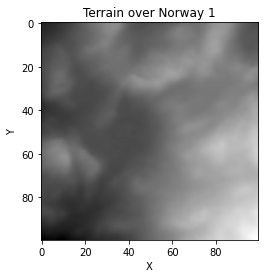

In [160]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from numpy.random import normal, uniform

# Load the terrain
terrain = imread('SRTM_data_Norway_1.tif')
print(terrain.shape)

N = 100
m = 5 # polynomial order
z = terrain[:N,:N]
# Creates mesh of image pixels
x = np.linspace(0,1, np.shape(z)[0])
y = np.linspace(0,1, np.shape(z)[1])
#Mesh grid is created
x, y = np.meshgrid(x,y)

x = x.ravel()
y = y.ravel()
z = z.ravel()
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(z.reshape(N,N), cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
plot_surface(x,y,z,N,"figures/realdata/terrain.png")
print("Max:",np.max(z))
print("Min:",np.min(z))
print("Mean:",np.mean(z))
print("Std:",np.std(z))

### Scaling the data

#### Min-max scaler

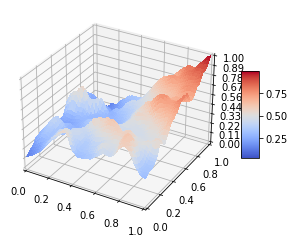

Max: 1.0
Min: 0.0
Mean: 0.44837234042553176
Std: 0.16506264869371642


In [51]:
#plot_surface(xy_train[:,0],xy_train[:,1],z_train,int((z_train.shape[0])**(0.5)))
minmax_z_scaler = MinMaxScaler().fit(z.reshape(-1,1))
z_scaled = minmax_z_scaler.transform(z.reshape(-1,1))
plot_surface(x,y,z_scaled.ravel(),N,"figures/realdata/minmax.png")
print("Max:",np.max(z_scaled))
print("Min:",np.min(z_scaled))
print("Mean:",np.mean(z_scaled))
print("Std:",np.std(z_scaled))

applying the min max scaler ensures we are dealing with values between [0,1]. Note that no distrotion is made.

In [161]:
minmax = MinMaxScaler().fit(z.reshape(-1,1))
z = minmax.transform(z.reshape(-1,1))
xy_train, xy_test, z_train, z_test = train_test_split(np.column_stack((x,y)),z,test_size=0.19, random_state = 42)
#z_train = z_train.reshape(-1,1)
#z_test = z_test.reshape(-1,1)

### OLS

#### Train and test error

    Train MSE  Test MSE      Train R2   Test R2
0    0.027365  0.026744  1.110223e-16 -0.001521
1    0.009903  0.010214  6.381253e-01  0.617500
2    0.005562  0.006099  7.967466e-01  0.771616
3    0.003871  0.003976  8.585514e-01  0.851121
4    0.003033  0.003073  8.891708e-01  0.884919
5    0.002594  0.002733  9.051923e-01  0.897655
6    0.002349  0.002487  9.141544e-01  0.906848
7    0.001562  0.001621  9.429044e-01  0.939292
8    0.001294  0.001316  9.527045e-01  0.950722
9    0.000938  0.000947  9.657331e-01  0.964530
10   0.000817  0.000821  9.701518e-01  0.969255
11   0.000760  0.000782  9.722249e-01  0.970712
12   0.000703  0.000734  9.743165e-01  0.972500
13   0.000662  0.000703  9.758067e-01  0.973660
14   0.000636  0.000673  9.767732e-01  0.974790
15   0.000577  0.000629  9.789328e-01  0.976447
16   0.000576  0.000616  9.789545e-01  0.976916
17   0.000551  0.000596  9.798491e-01  0.977680
18   0.000546  0.000588  9.800540e-01  0.977983
19   0.000521  0.000562  9.809488e-01  0

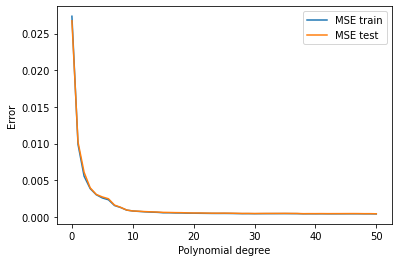

In [56]:
max_degree = 50

n_features = int((max_degree+1)*(max_degree+2)/2)
MSE_train = np.zeros(max_degree+1)
MSE_test = np.zeros(max_degree+1)
R2_train = np.zeros(max_degree+1)
R2_test = np.zeros(max_degree+1)

beta_degrees = pd.DataFrame()#index=range(n_features))#columns=["Degree "+str(i) for i in range(degree)])

for degree in range(max_degree+1):
    X_train = create_X(xy_train[:,0], xy_train[:,1], degree)
    X_test = create_X(xy_test[:,0], xy_test[:,1], degree)   
      
    beta, _ = fit_beta(X_train, z_train)   
    
    z_tilde = model_predict(X_train,beta)
    z_pred = model_predict(X_test,beta)

    MSE_train[degree] = MSE(z_train,z_tilde)
    MSE_test[degree] = MSE(z_test,z_pred)
    R2_train[degree] = R2(z_train,z_tilde)
    R2_test[degree] = R2(z_test,z_pred)

    #z_checking,_ = fit_beta(np.eye(X_test.shape[0]),z_test)

    df_b = pd.DataFrame(data = beta,index=range(beta.shape[0]),columns=['Degree '+str(degree)])
    beta_degrees = pd.concat([beta_degrees,df_b],axis=1)

scores_df = pd.DataFrame()
scores_df['Train MSE'] = MSE_train.tolist()
scores_df['Test MSE'] = MSE_test.tolist()
scores_df['Train R2'] = R2_train.tolist()
scores_df['Test R2'] = R2_test.tolist()
print(scores_df)

plt.plot(MSE_train,label="MSE train")
plt.plot(MSE_test,label="MSE test")
plt.xlabel('Polynomial degree')
plt.ylabel('Error')

plt.legend()
plt.savefig("figures/realdata/trainTest_MSE_unscaled.png")

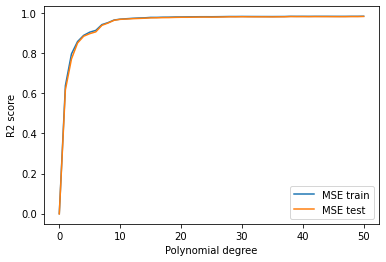

In [57]:
plt.plot(R2_train,label="MSE train")
plt.plot(R2_test,label="MSE test")
plt.xlabel('Polynomial degree')
plt.ylabel('R2 score')

plt.legend()
plt.savefig("figures/realdata/trainTest_R2_OLS_100.png")

#### Plotting the surface
Data should be sorted for better 3D plots

0.0004199894233632303
(8100, 1)


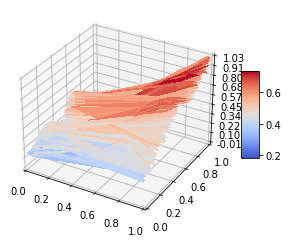

In [67]:
X_train = create_X(xy_train[:,0], xy_train[:,1], 50)
X_test = create_X(xy_test[:,0], xy_test[:,1], 50)   

#poly = LinearRegression()
#poly = poly.fit(X_train,z_train)
beta, _ = fit_beta(X_train, z_train)

z_tilde = model_predict(X_train,beta)
#z_tilde = poly.predict(X_train)

p = xy_train[:,0].argsort()
xy_train_sorted =xy_train[p]
z_tilde_sorted = z_tilde[p]
z_train_sorted = z_train[p]

p2 = xy_train_sorted[:,1].argsort()
xy_train_sorted = xy_train_sorted[p2]
z_tilde_sorted = z_tilde_sorted[p2]
z_train_sorted = z_train[p2]

print(MSE(z_tilde, z_train))

plot_surface(xy_train_sorted[:,0],xy_train_sorted[:,1],z_tilde_sorted.ravel(),90,"figures/realdata/fitted_surface_OLS_50")

#### Cross-validation

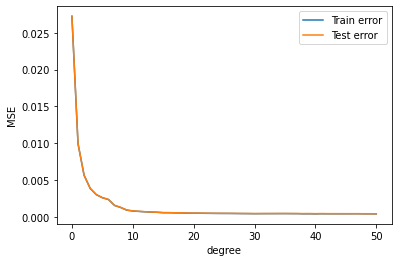

50
0.000439516755048452


In [153]:
max_degree = 50
kfold = KFold(n_splits = k, shuffle=True, random_state = 5)
#degrees_arr = np.arange(0,max_degree+1)

# Perform the cross-validation to estimate MSE
scores_KFold_train = np.zeros((max_degree+1, k))
scores_KFold_test = np.zeros((max_degree+1, k))
sk_scores_KFold_train = np.zeros(max_degree+1)

for i in range(max_degree+1):
    X = create_X(x, y, i)
    scores_KFold_train[i,:], scores_KFold_test[i,:] = crossVal(kfold, X, z)
    #sk_scores_KFold_train[i] = np.mean(cross_val_score(lin, X, z, scoring=make_scorer(mean_squared_error), cv=k))

mse_KFold_train = np.mean(scores_KFold_train, axis = 1)
mse_KFold_test = np.mean(scores_KFold_test, axis = 1)

plt.figure()
plt.plot(mse_KFold_train, label='Train error')
plt.plot(mse_KFold_test, label='Test error')

plt.xlabel('degree')
plt.ylabel('MSE')
plt.legend()
plt.savefig("figures/realdata/crossval_OLS.png")
plt.show()
print(np.argmin(mse_KFold_test))
print(np.min(mse_KFold_test))

In [70]:
print(mse_KFold_test[30])

0.0004691489551650558


### Ridge
#### Lambda optimization with cross-validation

(10000,)
(10000,)
1.0
Minimum error:  0.0063971757905982255
Lambda resulting in minimum error:  151.99110829529394


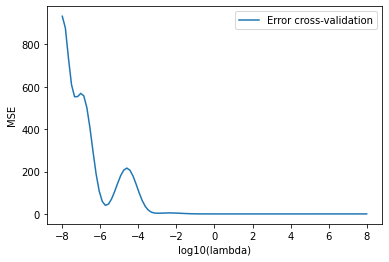

In [164]:
nlambdas = 100
lambdas = np.logspace(-8, 8, nlambdas)
k = 5
kfold = KFold(n_splits = k)#,shuffle=True, random_state = 5)
degree = 30
# Perform the cross-validation to estimate MSE
scores_KFold = np.zeros((nlambdas, k))
scores = np.zeros((nlambdas, k))
print(x.shape)
print(y.shape)
print(np.max(z))
#z = zscaler.fit_transform(z.reshape(-1,1))
for i in range(nlambdas):
    lmb = lambdas[i]
    X = create_X(x, y, degree)

    #Calc mean and std
    
    scores_KFold[i,:] = crossVal_ridge(kfold, X, z, lmb)   
    #clf = Ridge(alpha=lmb)
    #scores[i,:] = cross_val_score(clf, X, z, cv=k, scoring='neg_mean_squared_error')


estimated_mse_KFold = np.mean(scores_KFold, axis = 1)
estimated_mse_KFold_sk = np.mean(-scores,axis=1)


plt.figure()
plt.plot(np.log10(lambdas), estimated_mse_KFold, label='Error cross-validation')
#plt.plot(np.log10(lambdas),estimated_mse_KFold_sk,"--", label='Error cross-validation sklearn')
print("Minimum error: ",np.min(estimated_mse_KFold))
print("Lambda resulting in minimum error: ",lambdas[np.argmin(estimated_mse_KFold)])
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.savefig("figures/realdata/bestlamb_ridge_real.png")
plt.show()

#### Cross-validation with optimal lambda

In [156]:
def crossVal_ridge_train(kfold, X, z, lmb):
    '''
    A new function is defined to return the cross-validated train error as well.
    
    '''
    j = 0
    scores_KFold_test = np.zeros((kfold.get_n_splits()))
    scores_KFold_train = np.zeros((kfold.get_n_splits()))
    
    for train_inds, test_inds in kfold.split(X):
        
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]
  
        mean_X_train = np.mean(X_train,axis=0)
        mean_z_train = np.mean(z_train,axis = 0)
   
        #Scale data
        X_train = scale_data(X_train,mean_X_train)
        X_test = scale_data(X_test, mean_X_train)

        z_train =  z_train - mean_z_train
        z_test =  z_test - mean_z_train

        beta, _ = fit_beta_ridge(X_train, z_train, lmb)
        
        #Predict test data and calculate MSE
        z_tilde = model_predict(X_train, beta)
        z_pred = model_predict(X_test, beta)

        scores_KFold_test[j] = MSE(z_test, z_pred)
        scores_KFold_train[j] = MSE(z_train, z_tilde)
        j += 1 


    return scores_KFold_test, scores_KFold_train


#### Train test error

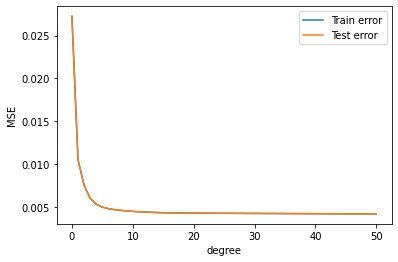

50
0.004244726830706528


In [166]:
max_degree = 50
kfold = KFold(n_splits = k, shuffle=True, random_state = 5)
#degrees_arr = np.arange(0,max_degree+1)

# Perform the cross-validation to estimate MSE
scores_KFold_train = np.zeros((max_degree+1, k))
scores_KFold_test = np.zeros((max_degree+1, k))
sk_scores_KFold_train = np.zeros(max_degree+1)
for i in range(max_degree+1):
    X = create_X(x, y, i)
    #, scores_KFold_test[i,:]
    scores_KFold_test[i,:], scores_KFold_train[i,:] = crossVal_ridge_train(kfold, X, z, 151.99)
    #sk_scores_KFold_train[i] = np.mean(cross_val_score(lin, X, z, scoring=make_scorer(mean_squared_error), cv=k))

mse_KFold_train = np.mean(scores_KFold_train, axis = 1)
mse_KFold_test = np.mean(scores_KFold_test, axis = 1)

plt.figure()
plt.plot(mse_KFold_train, label='Train error')
plt.plot(mse_KFold_test, label='Test error')

plt.xlabel('degree')
plt.ylabel('MSE')
plt.legend()
#plt.savefig("figures/realdata/crossval_Ridge.png")
plt.show()
print(np.argmin(mse_KFold_test))
print(np.min(mse_KFold_test))

### Lasso

#### Lambda optimization with cross-validation

1.0
Minimum error:  54.91693922282025
Lambda resulting in minimum error:  0.049770235643321135


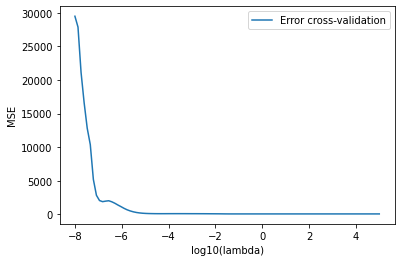

In [175]:
nlambdas = 100
lambdas = np.logspace(-8, 5, nlambdas)
k = 5
kfold = KFold(n_splits = k)#,shuffle=True, random_state = 5)
degree = 30
print(np.max(z))
# Perform the cross-validation to estimate MSE
scores_KFold = np.zeros((nlambdas, k))
scores = np.zeros((nlambdas, k))

for i in range(nlambdas):
    lmb = lambdas[i]
    X = create_X(x, y, degree)

    #Calc mean and std
    
    scores_KFold[i,:] = crossVal_lasso(kfold, X, z, lmb)   
    #clf = Ridge(alpha=lmb)
    #scores[i,:] = cross_val_score(clf, X, z, cv=k, scoring='neg_mean_squared_error')


estimated_mse_KFold = np.mean(scores_KFold, axis = 1)
estimated_mse_KFold_sk = np.mean(-scores,axis=1)


plt.figure()
plt.plot(np.log10(lambdas), estimated_mse_KFold, label='Error cross-validation')
#plt.plot(np.log10(lambdas),estimated_mse_KFold_sk,"--", label='Error cross-validation sklearn')
print("Minimum error: ",np.min(estimated_mse_KFold))
print("Lambda resulting in minimum error: ",lambdas[np.argmin(estimated_mse_KFold)])
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.savefig("figures/realdata/bestlamb_lasso_real.png")
plt.show()

#### Cross-validation with optimal lambda

In [182]:
def crossVal_lasso_train(kfold, X, z, lmb):
    j = 0
    scores_KFold_test = np.zeros((kfold.get_n_splits()))
    scores_KFold_train = np.zeros((kfold.get_n_splits()))
    lasso = Lasso(alpha = lmb,tol=0.001)
    for train_inds, test_inds in kfold.split(X):
        
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]

        lasso = lasso.fit(X_train,z_train)
        #Predict test data and calculate MSE
        z_tilde = lasso.predict(X_train)
        z_pred = lasso.predict(X_test)
        
        scores_KFold_test[j] = MSE(z_test, z_pred)
        scores_KFold_train[j] = MSE(z_train, z_tilde)
        j += 1 
    return scores_KFold_test, scores_KFold_train

#### Train test error

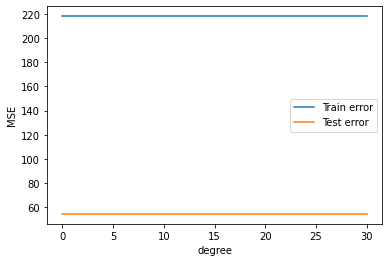

0
54.49151854981585


In [183]:
max_degree = 30
kfold = KFold(n_splits = k, shuffle=True, random_state = 5)


# Perform the cross-validation to estimate MSE
scores_KFold_train = np.zeros((max_degree+1, k))
scores_KFold_test = np.zeros((max_degree+1, k))
sk_scores_KFold_train = np.zeros(max_degree+1)
for i in range(max_degree+1):
    X = create_X(x, y, i)
    scores_KFold_test[i,:], scores_KFold_train[i,:] = crossVal_lasso_train(kfold, X, z, 0.049770235)

mse_KFold_train = np.mean(scores_KFold_train, axis = 1)
mse_KFold_test = np.mean(scores_KFold_test, axis = 1)

plt.figure()
plt.plot(mse_KFold_train, label='Train error')
plt.plot(mse_KFold_test, label='Test error')

plt.xlabel('degree')
plt.ylabel('MSE')
plt.legend()
plt.savefig("figures/realdata/crossval_traintest_Lasso.png")
plt.show()
print(np.argmin(mse_KFold_test))
print(np.min(mse_KFold_test))